<a href="https://colab.research.google.com/github/Rocketman17/SymCheck---Machine-Learning-Model-for-Disease-Detectection/blob/main/SymCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


In [ ]:
import pathlib

training_data ="/content/drive/My Drive/SymCheck/Training_Data"
data_dir = pathlib.Path(training_data)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

269


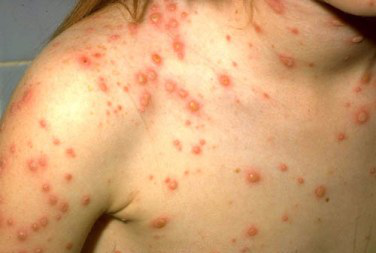

In [ ]:
roses = list(data_dir.glob('Chickenpox/*'))
PIL.Image.open(str(roses[0]))

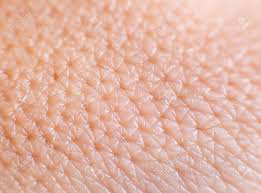

In [ ]:
roses = list(data_dir.glob('Normal_Skin/*'))
PIL.Image.open(str(roses[1]))

In [ ]:
batch_size = 10
img_height = 200
img_width = 200

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 269 files belonging to 4 classes.
Using 216 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 269 files belonging to 4 classes.
Using 53 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Chickenpox', 'Normal_Skin', 'Normal_eye', 'PinkEye']


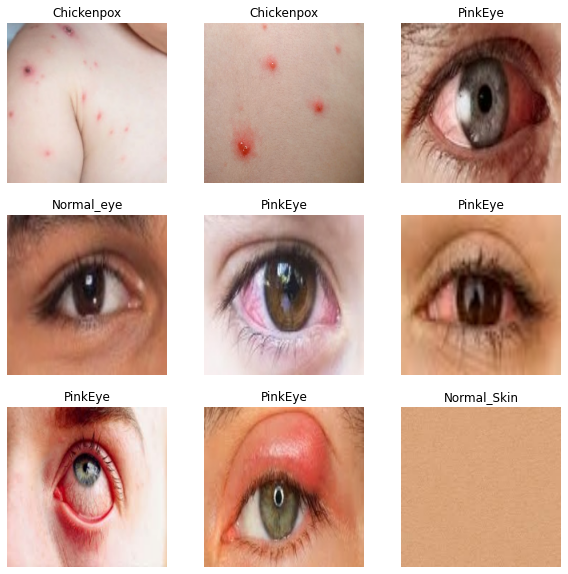

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 200, 200, 3)
(10,)


In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.06579698 0.8518927


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data Augmentation 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


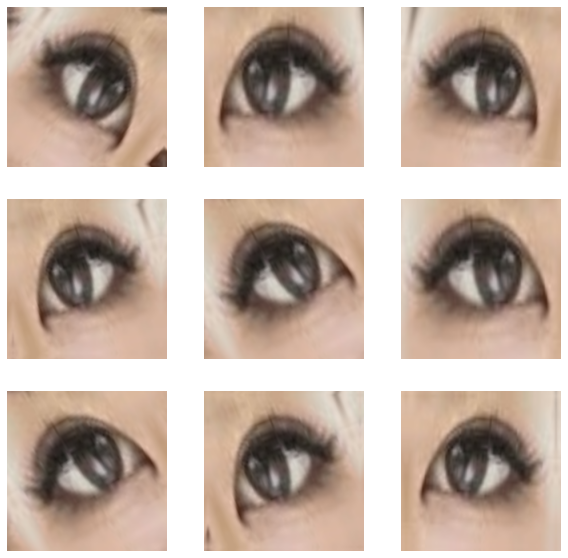

In [ ]:
# Visualize Augmented images 

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(12):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 4

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
22/22 [==============================] - 99s 5s/step - loss: 1.7751 - accuracy: 0.3467 - val_loss: 1.2776 - val_accuracy: 0.3208
Epoch 2/10
22/22 [==============================] - 10s 455ms/step - loss: 1.2344 - accuracy: 0.4337 - val_loss: 1.0615 - val_accuracy: 0.6226
Epoch 3/10
22/22 [==============================] - 10s 453ms/step - loss: 0.8440 - accuracy: 0.6739 - val_loss: 0.9159 - val_accuracy: 0.6226
Epoch 4/10
22/22 [==============================] - 10s 457ms/step - loss: 0.5805 - accuracy: 0.7723 - val_loss: 0.7410 - val_accuracy: 0.7547
Epoch 5/10
22/22 [==============================] - 10s 456ms/step - loss: 0.5412 - accuracy: 0.7663 - val_loss: 0.5209 - val_accuracy: 0.8113
Epoch 6/10
22/22 [==============================] - 10s 454ms/step - loss: 0.5437 - accuracy: 0.7699 - val_loss: 0.5821 - val_accuracy: 0.8113
Epoch 7/10
22/22 [==============================] - 10s 458ms/step - loss: 0.3837 - accuracy: 0.8223 - val_loss: 0.5386 - val_accuracy: 0.8491
Ep

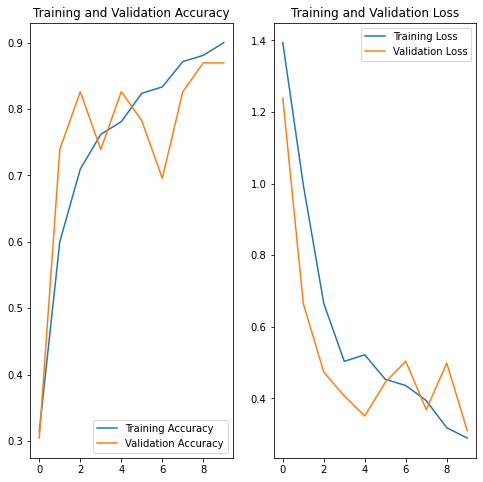

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

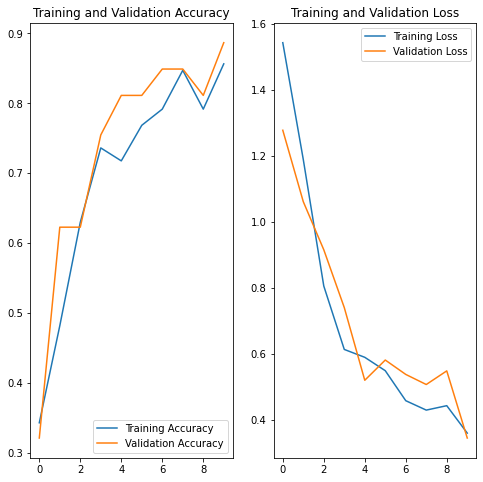

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("FinalModel.h5")

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/SymCheck/Models/FinalModel.h5')
class_names = ['Chickenpox', 'Normal_Skin', 'Normal_eye', 'PinkEye']

This image most likely belongs to PinkEye with a 99.99 percent confidence.


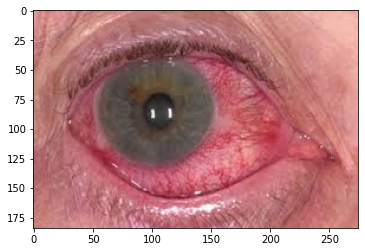

In [ ]:
testimg = '/content/drive/MyDrive/SymCheck/Testing images/images (2).jpg'

plt.show(testimg)
img = keras.preprocessing.image.load_img(
            testimg, target_size=(200, 200, 3)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testimg)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to Chickenpox with a 98.62 percent confidence.


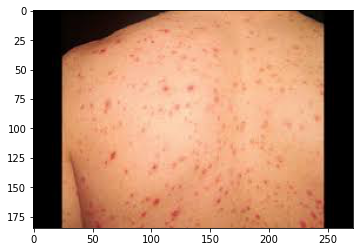

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images (7).jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to Normal_Skin with a 64.45 percent confidence.


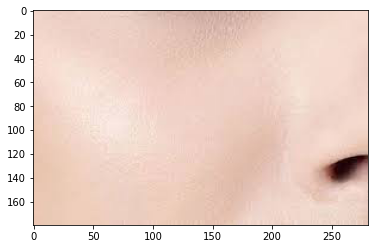

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images (9).jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to PinkEye with a 98.41 percent confidence.


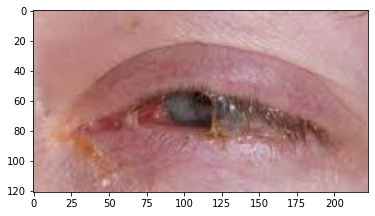

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images 1.jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to Chickenpox with a 77.89 percent confidence.


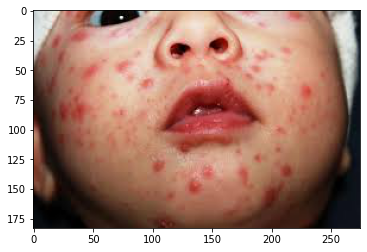

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images (3).jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to Chickenpox with a 85.63 percent confidence.


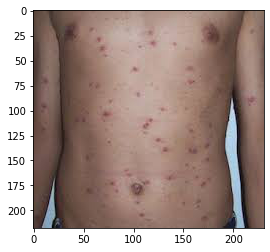

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images (8).jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to Normal_Skin with a 67.21 percent confidence.


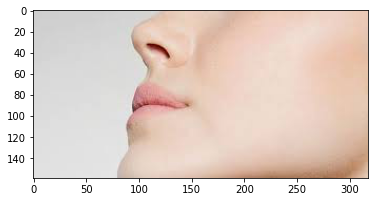

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images (10).jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to Normal_eye with a 94.70 percent confidence.


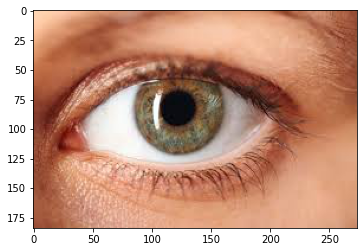

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images (17).jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

This image most likely belongs to Normal_Skin with a 74.20 percent confidence.


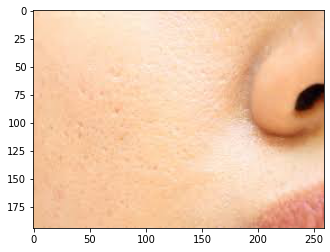

In [ ]:
testing = '/content/drive/MyDrive/SymCheck/Testing images/images (14).jpg'
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
testing = "/content/drive/MyDrive/SymCheck/Testing images"
plt.show(testing)
img = keras.preprocessing.image.load_img(
            testing, target_size=(200, 200, 2)
        )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
"This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
        )

img = mpimg.imread(testing)
imgplot = plt.imshow(img)
plt.show()

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")